In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re, os
import numpy as np
import xarray as xr
import tensorflow.keras as keras
import datetime
import pdb
import matplotlib.pyplot as plt
from src.utils import *
from src.score import *
from src.data_generator import *
from src.networks import *
from src.train import *

In [3]:
preddir = '/home/rasp/data/myWeatherBench/predictions/'

In [7]:
valdir = '/data/stephan/WeatherBench/5.625deg/'

In [9]:
z500_valid = load_test_data(f'{valdir}geopotential_500', 'z').drop('level')
t850_valid = load_test_data(f'{valdir}temperature_850', 't').drop('level')
valid = xr.merge([z500_valid, t850_valid])

In [43]:
exp_ids = ['83-resnet_d3_6h', '84-resnet_d3_1d', '85-resnet_d3_2d', '81-resnet_d3_dr_0.1', 
           '86-resnet_d3_4d', '71-resnet_d3_best_5d']
lead_times = [6, 24, 48, 72, 96, 120]

In [44]:
preds = []
for exp_id in exp_ids:
    preds.append(
        compute_weighted_rmse(
            xr.open_dataset(f'{preddir}/{exp_id}.nc'), 
            valid
        ).load()
    )

In [53]:
rmse = xr.open_dataset('/data/stephan/WeatherBench/baselines/rmse_5.625.nc')

In [25]:
rmse

<xarray.Dataset>
Dimensions:               (lead_time: 29)
Coordinates:
  * lead_time             (lead_time) int64 0 6 12 18 24 ... 144 150 156 162 168
    level                 int32 ...
    lev                   float64 ...
Data variables:
    z_persistence         (lead_time) float64 ...
    t_persistence         (lead_time) float64 ...
    z_climatology         float64 1.075e+03
    t_climatology         float64 ...
    z_weekly_climatology  float64 815.7
    t_weekly_climatology  float64 ...
    z_lr_6h_iter          (lead_time) float64 ...
    t_lr_6h_iter          (lead_time) float64 ...
    z_lr_3d               float64 ...
    t_lr_3d               float64 ...
    z_lr_5d               float64 ...
    t_lr_5d               float64 ...
    z_cnn_6h_iter         (lead_time) float64 ...
    t_cnn_6h_iter         (lead_time) float64 ...
    z_cnn_3d              float64 ...
    t_cnn_3d              float64 ...
    z_cnn_5d              float64 ...
    t_cnn_5d              float64 ...
    t_tigge               (lead_time) float64 ...
    z_tigge               (lead_time) float64 ...
    z_t42                 (lead_time) float64 ...
    t_t42                 (lead_time) float64 ...

In [60]:
def create_plot(var, save_fn=None, ax=None, legend=False):
    # Color settings
    c_lri = '#ff7f00'
    c_lrd = '#ff7f00'
    c_cnni = '#e41a1c'
    c_cnnd = '#e41a1c'
    c_tigge = '#984ea3'
    c_t42 = '#4daf4a'
    c_t63 = '#377eb8'
    c_persistence = '0.2'
    c_climatology = '0.5'
    c_weekly_climatology = '0.7'
    
    if ax is None: fig, ax = plt.subplots(1, 1, figsize=(5, 4)) 
    rmse[var+'_persistence'].plot(c=c_persistence, label='Persistence', lw=3, ax=ax)
    ax.axhline(rmse[var+'_climatology'], ls='--', c=c_climatology, label='Climatology', lw=3)
    ax.axhline(rmse[var+'_weekly_climatology'], ls='--', c=c_weekly_climatology, label='Weekly clim.', lw=3)
    rmse[var+'_t42'].plot(c=c_t42, label='IFS T42', lw=3, ax=ax)
    rmse[var+'_t63'][::2].plot(c=c_t63, label='IFS T63', lw=3, ax=ax)
    rmse[var+'_tigge'].plot(c=c_tigge, label='Operational', lw=3, ax=ax)
#     rmse[var+'_lr_6h_iter'].plot(c=c_lri, label='LR (iterative)', lw=3, ax=ax)
#     ax.scatter([3*24], [rmse[var+'_lr_3d']], c=c_lrd, s=100, label='LR (direct)', lw=2, edgecolors='k', zorder=10)
#     ax.scatter([5*24], [rmse[var+'_lr_5d']], c=c_lrd, s=100, lw=2, edgecolors='k', zorder=10)
#     rmse[var+'_cnn_6h_iter'].plot(c=c_cnni, label='CNN (iterative)', lw=3, ax=ax)
#     ax.scatter([3*24], [rmse[var+'_cnn_3d']], c=c_cnnd, s=100, label='CNN (direct)', lw=2, edgecolors='k', zorder=10)
#     ax.scatter([5*24], [rmse[var+'_cnn_5d']], c=c_cnnd, s=100, lw=2, edgecolors='k', zorder=10)
    
    
    if var == 'z':
        ax.set_ylim(0, 1200)
        ax.set_ylabel(r'Z500 RMSE [m$^2$ s$^{-2}$]')
        ax.set_title('a) Z500')
    elif var == 't':
        ax.set_ylim(0, 6)
        ax.set_ylabel(r'T850 RMSE [K]')
        ax.set_title('b) T850')
        
    if legend: ax.legend(loc=2, framealpha=1)
    ax.set_xlim(0, 122)
    ax.set_xticks(range(0, 121, 24))
    ax.set_xticklabels(range(6))
    ax.set_xlabel('Forecast time [days]')
    
    if not save_fn is None: 
        plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
        fig.savefig(save_fn)

In [30]:
ds_raw = xr.open_dataset('/data/stephan/Weyn/forecast_dlwp-cs-s2s_4var-t850_UNET2.1_WeatherBench.nc')

In [37]:
ds = regrid(ds_raw, ddeg_out=5.625)

Reuse existing file: bilinear_91x180_32x64_peri.nc
using dimensions ('lat', 'lon') from data variable z500 as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z500 as the horizontal dimensions for this dataset.


In [38]:
ds = ds.rename({'f_hour': 'lead_time', 'z500': 'z', 't850': 't'})

In [39]:
rmse_weyn = evaluate_iterative_forecast(ds, valid).load()

In [40]:
rmse_weyn

<xarray.Dataset>
Dimensions:    (lead_time: 56)
Coordinates:
  * lead_time  (lead_time) float64 6.0 12.0 18.0 24.0 ... 324.0 330.0 336.0
Data variables:
    z_rmse     (lead_time) float64 103.2 122.1 136.1 ... 1.039e+03 1.044e+03
    t_rmse     (lead_time) float64 1.038 1.159 1.222 1.295 ... 4.453 4.46 4.48

In [54]:
t63 = xr.open_dataset('/data/stephan/WeatherBench/baselines/t63_5.625deg.nc')

In [55]:
t63_rmse = evaluate_iterative_forecast(t63, valid).load().rename({'z_rmse': 'z_t63', 't_rmse': 't_t63'})

In [56]:
rmse = xr.merge([rmse, t63_rmse])

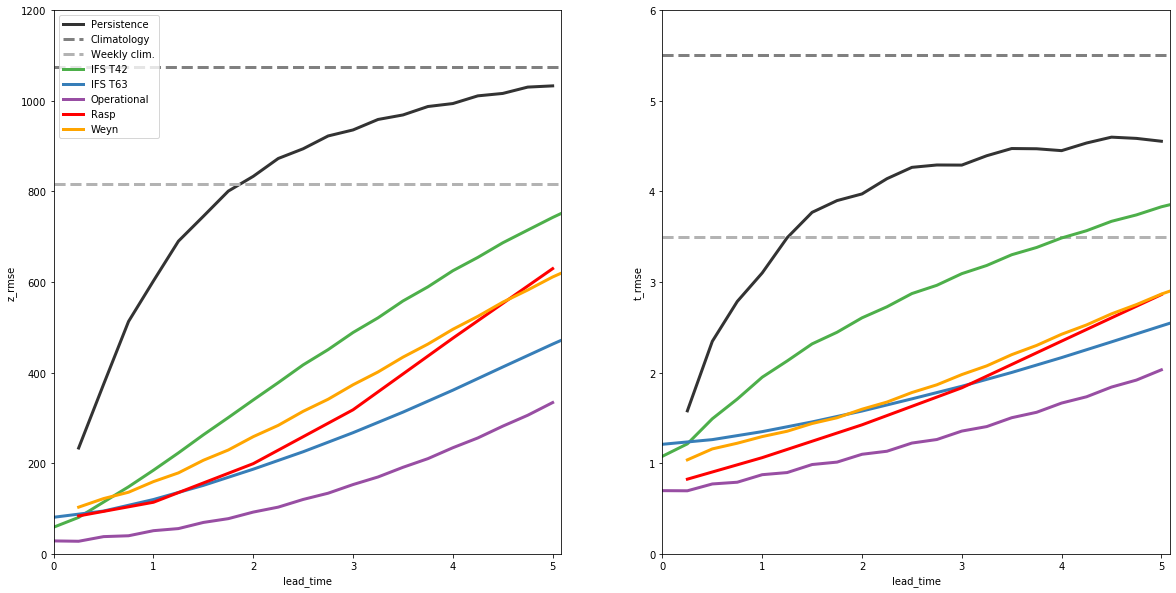

In [101]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
create_plot('z', ax=ax1)
create_plot('t', ax=ax2)
ax1.plot(lead_times, [p.z_rmse for p in preds], lw=3, c='r', label='Rasp')
ax2.plot(lead_times, [p.t_rmse for p in preds], lw=3, c='r')
rmse_weyn.z_rmse.plot(ax=ax1, lw=3, c='orange', label='Weyn')
rmse_weyn.t_rmse.plot(ax=ax2, lw=3, c='orange')
ax1.legend(loc=2, ncol=1, fontsize=10)

In [63]:
preds2 = []
for exp_id in exp_ids:
    preds2.append(
        compute_weighted_rmse(
            xr.open_dataset(f'{preddir}/{exp_id}.nc'), 
            valid,
            mean_dims=['time']
        ).load()
    )

In [88]:
p87 = compute_weighted_rmse(
    xr.open_dataset(f'{preddir}/87-resnet_d3_6h_tisr.nc'), 
            valid,
            mean_dims=['time']
        ).load()

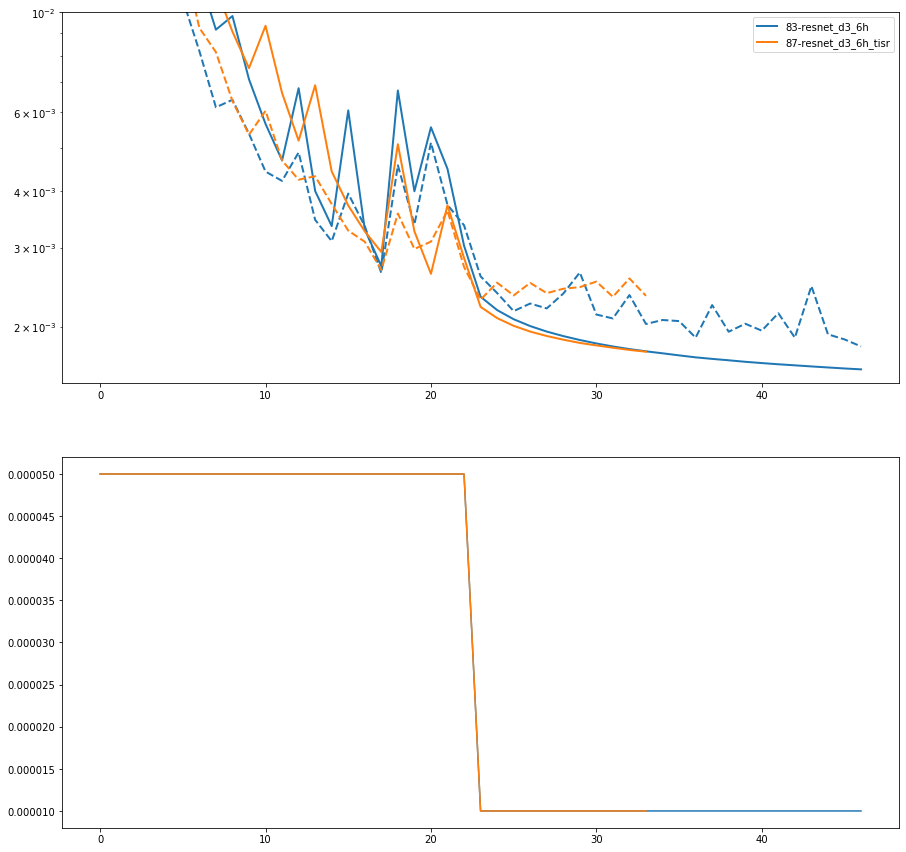

In [100]:
plot_losses('/home/rasp/data/myWeatherBench/predictions/saved_models/', 
            [83, 87], log=True, ylim=(0.0015, 0.01)
        )

In [92]:
p

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t_rmse   float64 0.8248
    z_rmse   float64 83.79

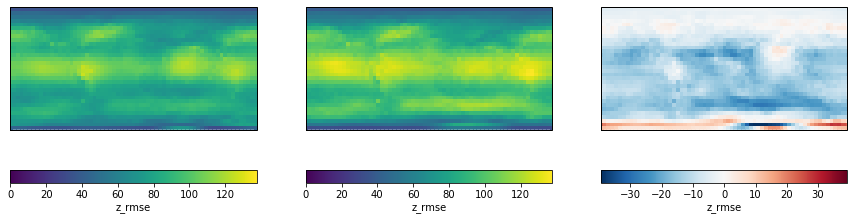

In [93]:
p = preds2[0]
var = 'z_rmse'
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': ccrs.PlateCarree()})
m = np.max([preds[0][var].max(), p87[var].max()])
p[var].plot(ax=ax1, vmin=0, vmax=m, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'})
p87[var].plot(ax=ax2, vmin=0, vmax=m, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'})
diff = p[var] - p87[var]
diff.plot(ax=ax3, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'})

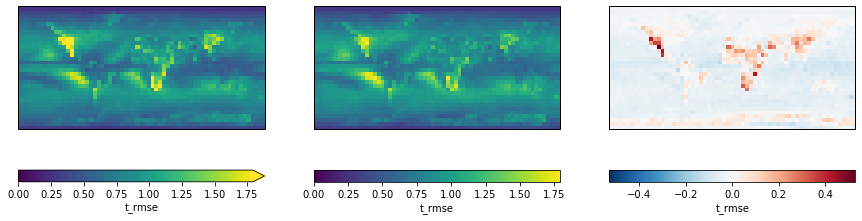

In [94]:
p = preds2[0]
var = 't_rmse'
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': ccrs.PlateCarree()})
m = np.max([preds[0][var].max(), p87[var].max()])
p[var].plot(ax=ax1, vmin=0, vmax=m, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'})
p87[var].plot(ax=ax2, vmin=0, vmax=m, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'})
diff = p[var] - p87[var]
diff.plot(ax=ax3, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'})

In [65]:
rmse_weyn2 = evaluate_iterative_forecast(ds, valid, mean_dims=['time']).load()

In [79]:
import cartopy.crs as ccrs

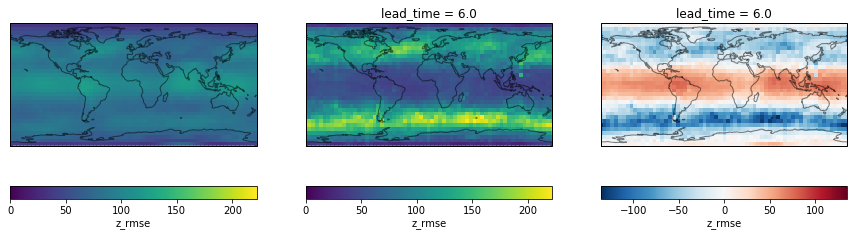

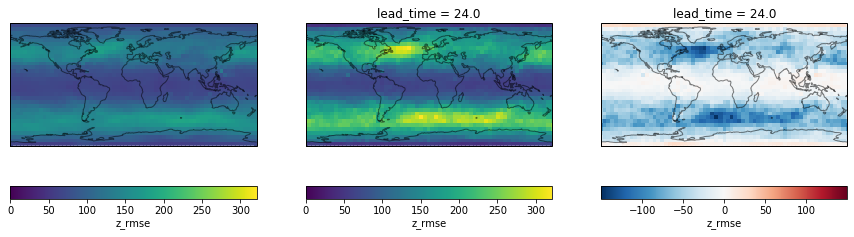

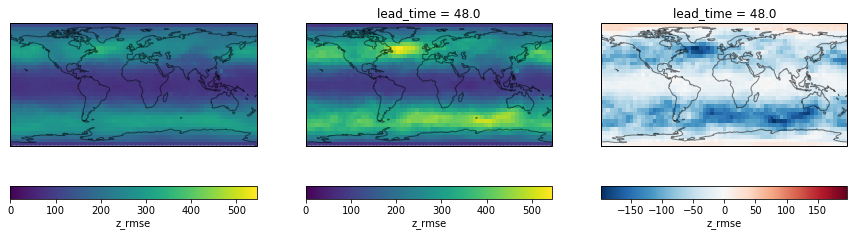

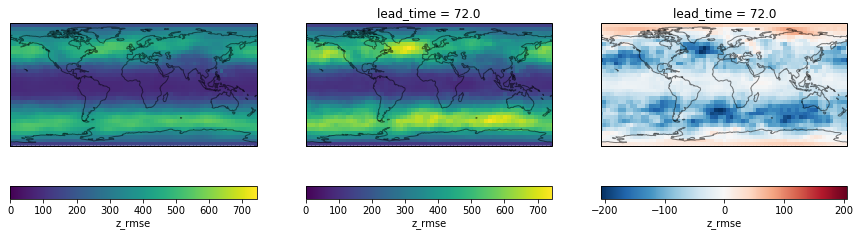

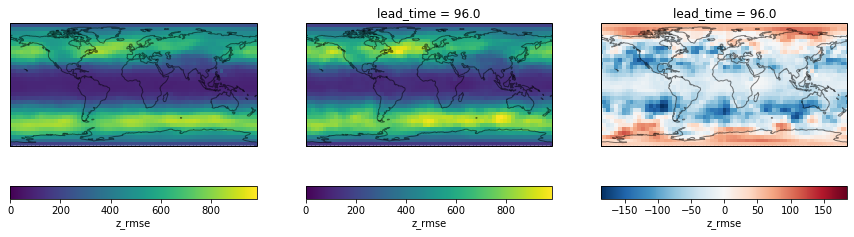

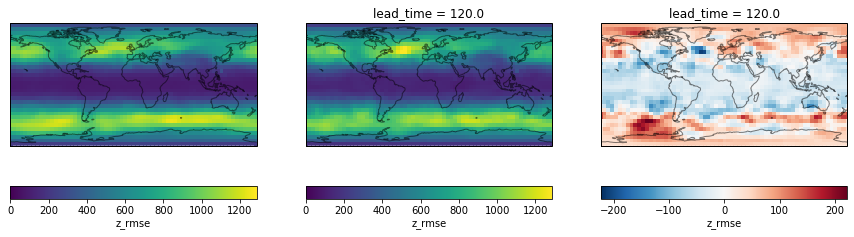

In [89]:
var = 'z_rmse'
for l, p in zip(lead_times, preds2):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': ccrs.PlateCarree()})
    m = np.max([p[var].max(), rmse_weyn2.sel(lead_time=l)[var].max()])
    p[var].plot(ax=ax1, vmin=0, vmax=m, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'})
    rmse_weyn2.sel(lead_time=l)[var].plot(ax=ax2, vmin=0, vmax=m, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'})
    diff = p[var] - rmse_weyn2.sel(lead_time=l)[var]
    diff.plot(ax=ax3, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'})
    for ax in [ax1, ax2, ax3]:
        ax.coastlines(alpha=0.5)

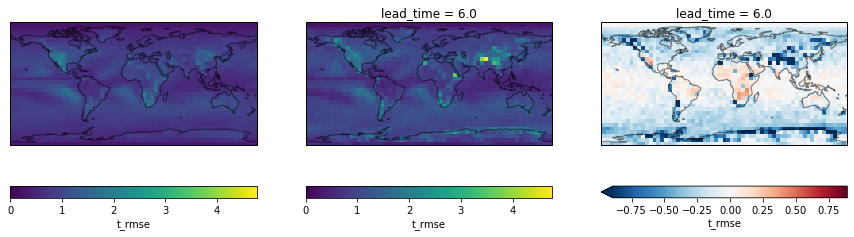

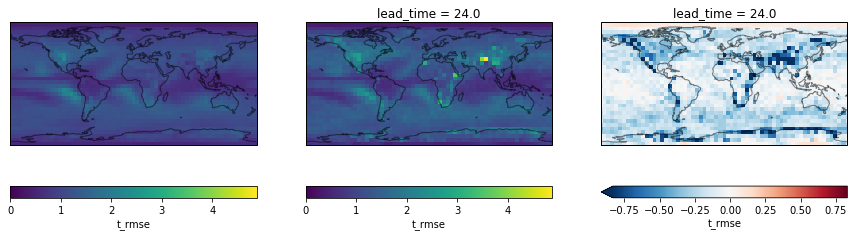

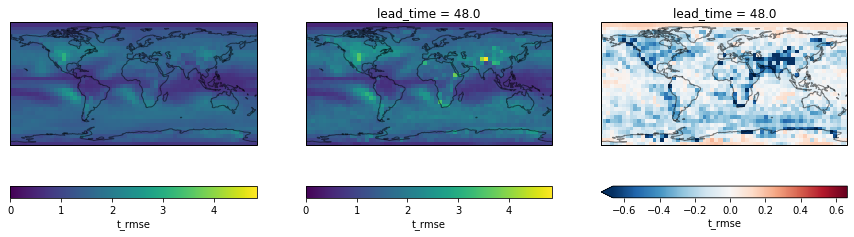

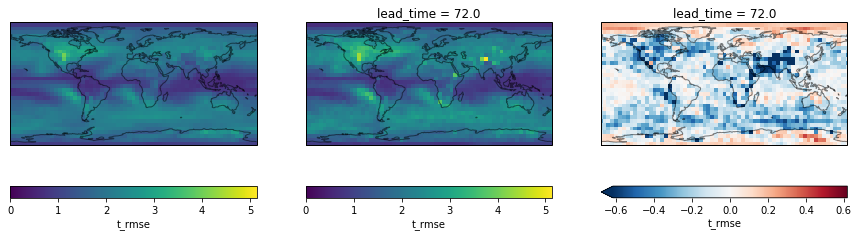

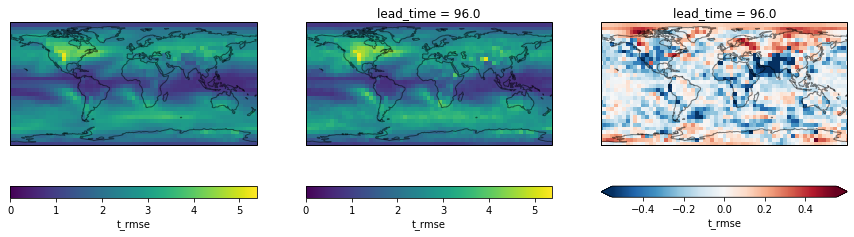

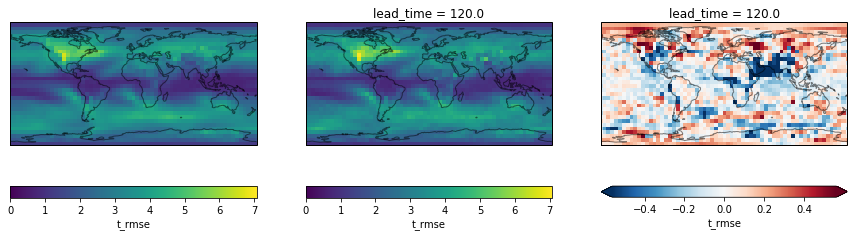

In [90]:
var = 't_rmse'
for l, p in zip(lead_times, preds2):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': ccrs.PlateCarree()})
    m = np.max([p[var].max(), rmse_weyn2.sel(lead_time=l)[var].max()])
    p[var].plot(ax=ax1, vmin=0, vmax=m, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'})
    rmse_weyn2.sel(lead_time=l)[var].plot(ax=ax2, vmin=0, vmax=m, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'})
    diff = p[var] - rmse_weyn2.sel(lead_time=l)[var]
    diff.plot(ax=ax3, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'}, robust=True)
    for ax in [ax1, ax2, ax3]:
        ax.coastlines(alpha=0.5)